# Milestone 4

# 1. Problem Statement Refinement

The research question remains to explore the ability of machine learning models to distinguish between real and AI-generated reviews. As language models become better and better at generating realistic text, being able to distinguish between human and machine generated text becomes more important. Fake reviews in our dataset are generated by GPT-2 and are easily distinguishable from real reviews because they are often imcomplete, contain logical inconsistensies or irrelevant information. In the previous milestone, we were able to effectively distinguishes between the two types with a basic CNN model. Moving forward, we aim to improve classification accuracy by incorporating pre-trained language models. Additionally, error analysis will be conducted to identify the features of samples incorrectly classified by the model. Time permitting, we will extend our investigation to ascertain if our text classification model can also identify fake reviews created by more sophisticated AI systems, such as  LLaMa-2. If time allows, we plan to refine the fake reviews using these advanced models and further explore alternative classification strategies, including in-context learning with generative LMs.

# 2. Comprehensive EDA Review

Our goal is to train a model that is able to distinguish real and fake reviews. Therefore, we downloaded data from Kaggle (https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset). This dataset consists of 40,000 reviews for 10 common categories of groceries, 1) Books; 2) Clothing, Shoes, and Jewelry; 3) Home and Kitchen; 4) Electronics; 5) Movies and TV; Sports and Outdoors; 6) Kindle Store; 7) Pet Supplies; 8) Tools and Home Improvement; 9) Toys; and 10) Games. For each review, we have a text-based comment written by either real customers or computers and an integer-based rating spanning from 1 to 5.

Furthermore, we checked several descriptive statistics of our dataset. 1) Ratings: we plotted histograms of ratings. From the figure, we observed the mean values are 4.259 and 4.253 for CG (Computer generated) and OR (Original review) reviews, respectively (Figure 1). 2) Sentences (text-based comments): we calculated the length of each comment and found the average length is 306 and 397 for CG and OR (Figure 2). 3) Grocery categories: each category has 1897 to 2365 reviews. “Kindle_Store” is the largest one where we have 4730 (CG: 2365 and OR: 2365) reviews in total. “Toys_and_Games” has the least number of reviews (CG: 1897 and OR: 1897) (Figure 3).

We have equal numbers of samples in both CG and OR classes. Also, CG and OR reviews also didn’t differ in the ratings distribution and had a similar number of reviews in each of the ten categories, suggesting both ratings and grocery categories exhibit balanced conditional distributions. Thus, there appears to be no issue of class imbalance that could detrimentally impact the model's performance. Furthermore, there are no missing values in the dataset. For the sole numerical feature, "ratings," is already on a standard scale ranging from 1 to 5, so there are also no outliers.
We also examined the relationship between ratings and sentence length of CG and OR reviews in each category and did not note any significant differences between the two labels and across categories. This suggests that there are no evident patterns and we should implement more complex models to identify meaningful characteristics to tell real and fake reviews.

In surmmary, we see that there is a balanced distribution of CG and OR samples, indicating that manual class-balancing strategies, such as class-balanced loss, are not required. Furthermore, the distribution of structured features like Rating and Category, as well as context-independent text features like sentence length, appear to be similar across both CG and OR samples. In milestone 2 we reported that compared to the human reviews, the computer-generated reviews contained more incomplete sentences, logical inconsistencies, and irrelevant information. We can distinguish between human and computer-generated reviews by taking advantage of these syntactic differences using a contextualized text model.

## 2.1. Load data and necessary packages

In [1]:
# import all necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Input
from tensorflow.keras.layers import Conv1D, Flatten, MaxPool1D
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import pandas as pd
import argparse

np.random.seed(109)

In [9]:
# read in our dataset
data = pd.read_csv("fake reviews dataset.csv")
corpus = data.text_.to_list()

label_2_id = {"CG": 0, "OR": 1}
labels = np.array([label_2_id[label] for label in data.label])

ratings = data.rating.to_numpy()

## 2.2. Visualize Data

### 2.2.1 Figure 1: Histogram of ratings

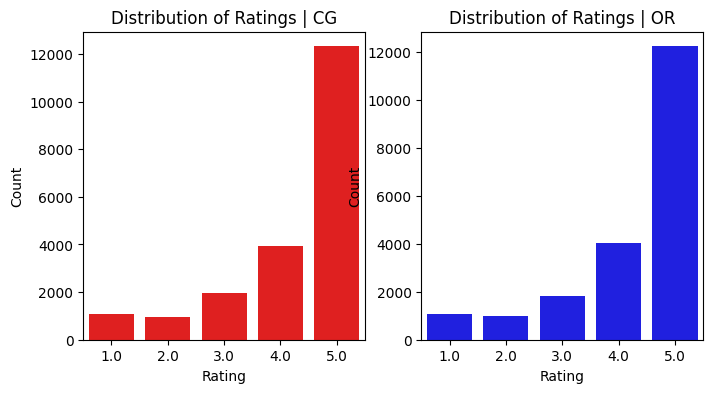

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot 1: Conditional Distribution of Rating Given Label
for i, label in enumerate(data['label'].unique()):
    color = "red" if label == "CG" else "blue"
    sns.countplot(x='rating', data=data[data['label'] == label], ax=axes[i], color = color)
    axes[i].set_title(f'Distribution of Ratings | {label}')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Count')

### 2.2.2 Figure 2: Histogram of sentence lengths

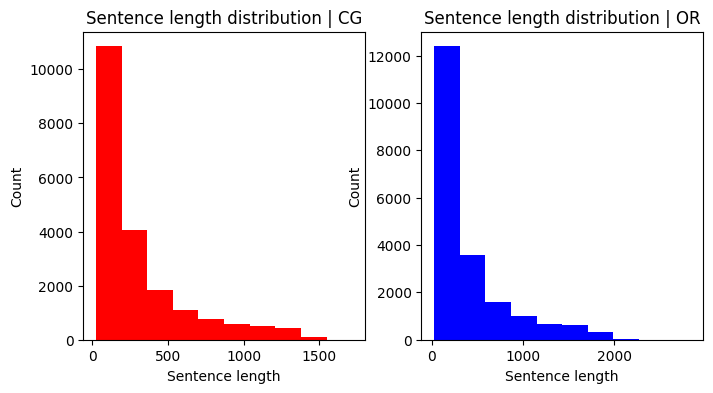

In [11]:
fig = fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(8, 4))
ax1.hist((data.loc[data["label"] == "CG", "text_"]).str.len(), color="red")
ax1.set_title("Sentence length distribution | CG")
ax1.set_xlabel("Sentence length")
ax1.set_ylabel("Count")

ax2.hist((data.loc[data["label"] == "OR", "text_"]).str.len(), color="blue")
ax2.set_title("Sentence length distribution | OR")
ax2.set_xlabel("Sentence length")
ax2.set_ylabel("Count")

plt.show()

### 2.2.3 Figure 3: Distribution of number of reviews in each category for CG and OR reviews

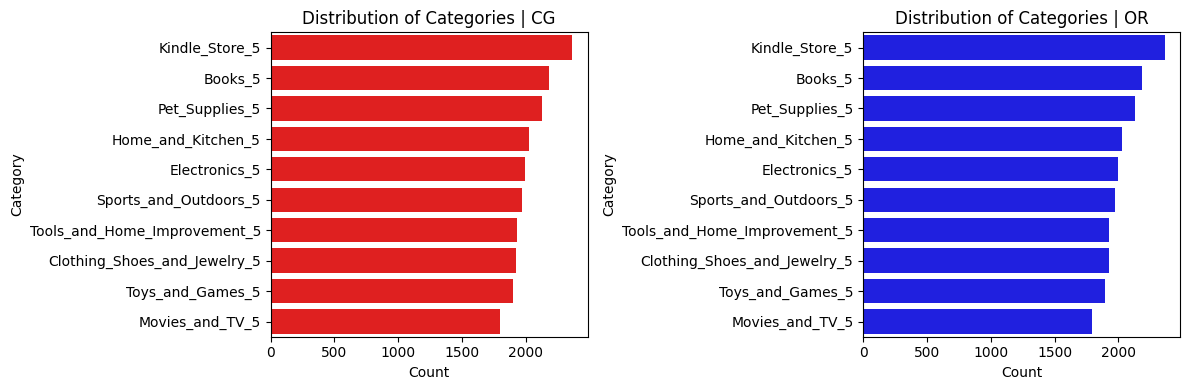

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 2: Conditional Distribution of Category Given Label
for i, label in enumerate(data['label'].unique()):
    color = "red" if label == "CG" else "blue"
    category_order = data[data['label'] == label]['category'].value_counts().index
    sns.countplot(y='category', data=data[data['label'] == label], ax=axes[i], order=category_order, color = color)
    axes[i].set_title(f'Distribution of Categories | {label}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Category')

plt.tight_layout()
plt.show()

# 3. Baseline Model Selection and Justification

### Our rationales of baseline model selection

We tried two baseline models: 1) Embeddings with Fully Connected Network, and 2) Embeddings with Conv1D. Our aim in selecting these models was to have a balance between simplicity and effectiveness. Our EDA highlighted only semantic differences between CG and OR reviews. To address this, we prioritized models that could generate word embeddings capable of capturing the meaning of words and their surrounding context. Hence, we chose these two models, which we consider to be the simplest but capable of understanding word meanings and completing the classification task. Furthermore, as our final strategy utilizing language models (LMs), we wanted to have our baseline models built on similar principles, leveraging vector representations of words. This approach also ensures a fair benchmarking comparison with our final model.

Additionally, both baseline models offer sufficient interpretability. We utilized the word embeddings they generated and projected them into a 2D space using t-SNE. This visualization  allows us to interpret how these embeddings classify different reviews and understand the rationale behind classifications (details are in Part 4).

### Training process (3.2, 3.3, and 3.4)

We use both text-based reviews and the corresponding ratings as inputs for our models. We first tokenized all sentences, built a dictionary for all words and encoded each review based on the word IDs. Subsequently, we applied padding to all encoded sentences, ensuring uniform length by padding with zeros to match the length of the longest sentence(s). Additionally, we encoded the labels 'CG' and 'OR' as 0 and 1, respectively.

Following this, we splited the entire dataset into training data (70%), test data (20%), and validation data (10%). The models were then fed with the training data, consisting of sentences and ratings, and trained over 10 epochs (where we found the losses level off on the validation data) with a batch size of 128. To assess their performance, we evaluated the models on the test data and computed the accuracy.

### Model details (3.3 and 3.4)

- Baseline model 1 (Embeddings + FCN): This model consists of 1) an Embedding layer (generating embeddings of words), 2) a Flatten layer, 3) a Concatenate layer (combining sentences and ratings), 4) a Dense layer, and 5) a Dense layer with a softmax function (output layer).

- Baseline model 2 (Embeddings + Conv1D): This model consists of 1) an Embedding layer (generating embeddings of words), 2) a Conv1D layer (capturing semantic information), 3) a MaxPooling1D layer, 4) a Flatten layer, 5) a Concatenate layer (combining sentences and ratings), and 6) a Dense layer with a softmax function (output layer).

## Initial results

The test accuracy of models 1 and 2 is 92.2% and 92.6% respectively (comparision will be disscussed in Part 4). We think the results are already very good and these models basically achieved our goals.

## 3.2. Data preprocessing

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
max_len = max([len(seq) for seq in sequences])
max_vocab = len(tokenizer.index_word) + 1
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split training, validation, and test data

# use 20% as test data
train_sentences, test_sentences, train_ratings, test_ratings, train_labels, test_labels = \
train_test_split(padded_sequences, ratings, labels, test_size=0.2, random_state=109)

# use 80%*12.5%=10% as validation data and 70% as training data
train_sentences, val_sentences, train_ratings, val_ratings, train_labels, val_labels = \
train_test_split(train_sentences, train_ratings, train_labels, test_size=0.125, random_state=109)

## 3.3 Baseline Model 1 (Embedding + FCN)

In [ ]:
text_input = Input(shape=(max_len,), name="TextInput")
rating_input = Input(shape=(1,), name="RatingInput")

# generate word embedding
embedding_layer = Embedding(max_vocab, 36, mask_zero=True)(text_input)
flatten_layer = Flatten()(embedding_layer)

# incorporate ratings
concatenate_layer = Concatenate()([flatten_layer, rating_input])

# dense layer
dense_layer = Dense(256, activation='sigmoid')(concatenate_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

baseline_model_1 = Model(inputs=[text_input, rating_input], outputs=output_layer)
baseline_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 521)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 521, 36)              1569492   ['TextInput[0][0]']           
                                                                                                  
 flatten (Flatten)           (None, 18756)                0         ['embedding[0][0]']           
                                                                                                  
 RatingInput (InputLayer)    [(None, 1)]                  0         []                            
                                                                                              

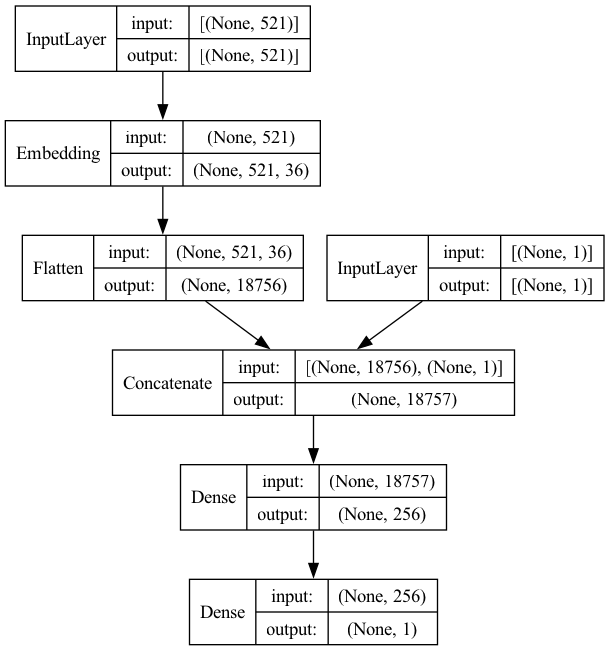

In [ ]:
# Plotting the model
plot_model(baseline_model_1, show_shapes=True, show_layer_names=False)

In [ ]:
baseline_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
baseline_model_1.fit(x=[train_sentences, train_ratings],
          y=train_labels,
          validation_data=([val_sentences, val_ratings], val_labels),
          epochs=10,
          batch_size=128)

baseline_model_1.save_weights("baseline_model_1_FCN")

Epoch 1/10
222/222 [==============================] - 5s 21ms/step - loss: 0.3368 - accuracy: 0.8486 - val_loss: 0.2003 - val_accuracy: 0.9214
Epoch 2/10
222/222 [==============================] - 4s 20ms/step - loss: 0.1404 - accuracy: 0.9466 - val_loss: 0.1843 - val_accuracy: 0.9288
Epoch 3/10
222/222 [==============================] - 4s 20ms/step - loss: 0.0886 - accuracy: 0.9678 - val_loss: 0.1946 - val_accuracy: 0.9278
Epoch 4/10
222/222 [==============================] - 4s 20ms/step - loss: 0.0546 - accuracy: 0.9825 - val_loss: 0.2221 - val_accuracy: 0.9256
Epoch 5/10
222/222 [==============================] - 4s 20ms/step - loss: 0.0313 - accuracy: 0.9916 - val_loss: 0.2443 - val_accuracy: 0.9226
Epoch 6/10
222/222 [==============================] - 4s 20ms/step - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.2744 - val_accuracy: 0.9228
Epoch 7/10
222/222 [==============================] - 4s 20ms/step - loss: 0.0091 - accuracy: 0.9986 - val_loss: 0.2926 - val_accuracy: 0.9214

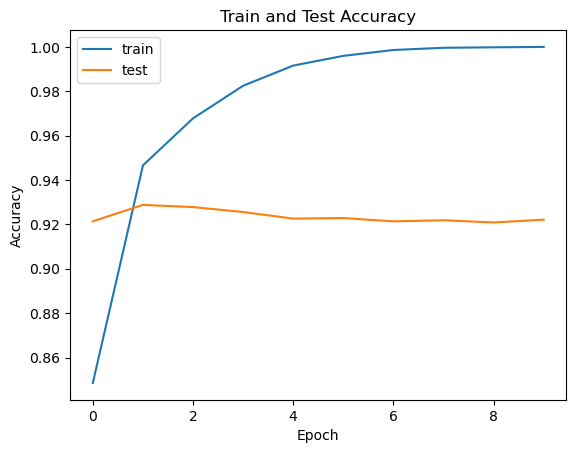

In [ ]:
plt.plot(baseline_model_1.history.history['accuracy'], label='train')
plt.plot(baseline_model_1.history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
test_loss, test_accuracy = baseline_model_1.evaluate([test_sentences, test_ratings], test_labels)
print("Baseline Model 1 test accuracy:", test_accuracy)

253/253 [==============================] - 1s 2ms/step - loss: 0.3029 - accuracy: 0.9221
Baseline Model 1 test accuracy: 0.9220972061157227


## 3.4. Baseline Model 2 (Embedding + Conv1D)

In [ ]:
text_input = Input(shape=(max_len,), name="TextInput")
rating_input = Input(shape=(1,), name="RatingInput")

# generate word embedding
embedding_layer = Embedding(max_vocab, 36, mask_zero=True)(text_input)
# integrate semantic information
conv_layer = Conv1D(filters=36, kernel_size=3, padding='same', activation='relu')(embedding_layer)
maxpooling_layer = MaxPool1D(pool_size=2)(conv_layer)
flatten_layer = Flatten()(maxpooling_layer)

# incorporate ratings
concatenate_layer = Concatenate()([flatten_layer, rating_input])

# dense layer
output_layer = Dense(1, activation='sigmoid')(concatenate_layer)

baseline_model_2 = Model(inputs=[text_input, rating_input], outputs=output_layer)
baseline_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 521)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 521, 36)              1569492   ['TextInput[0][0]']           
                                                                                                  
 conv1d (Conv1D)             (None, 521, 36)              3924      ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 260, 36)              0         ['conv1d[0][0]']              
 D)                                                                                         

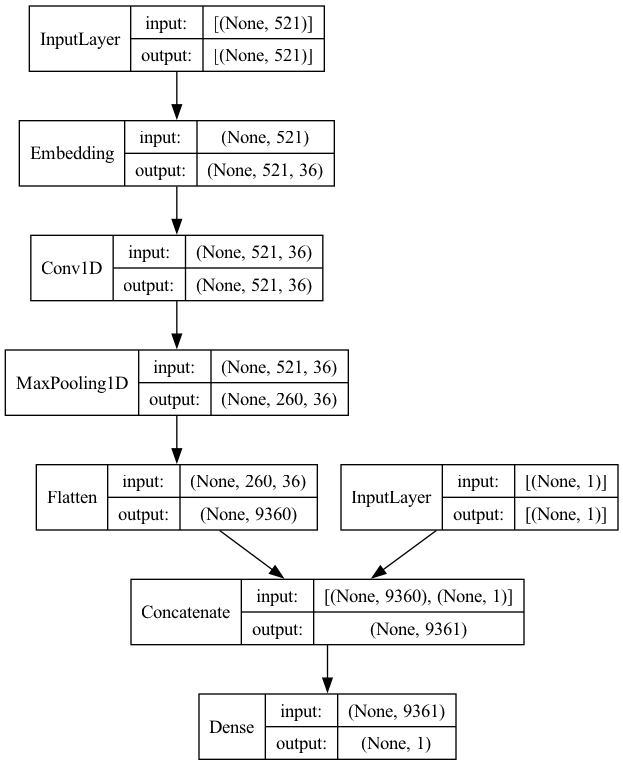

In [ ]:
# Plotting the model
plot_model(baseline_model_2, show_shapes=True, show_layer_names=False)

In [ ]:
baseline_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
baseline_model_2.fit(x=[train_sentences, train_ratings],
          y=train_labels,
          validation_data=([test_sentences, test_ratings], test_labels),
          epochs=10,
          batch_size=128)

baseline_model_2.save_weights("baseline_model_2_Conv1D")

Epoch 1/10
222/222 [==============================] - 4s 17ms/step - loss: 0.3760 - accuracy: 0.8130 - val_loss: 0.1993 - val_accuracy: 0.9199
Epoch 2/10
222/222 [==============================] - 4s 17ms/step - loss: 0.1478 - accuracy: 0.9428 - val_loss: 0.1813 - val_accuracy: 0.9306
Epoch 3/10
222/222 [==============================] - 4s 17ms/step - loss: 0.1006 - accuracy: 0.9628 - val_loss: 0.1947 - val_accuracy: 0.9287
Epoch 4/10
222/222 [==============================] - 4s 18ms/step - loss: 0.0761 - accuracy: 0.9714 - val_loss: 0.2043 - val_accuracy: 0.9320
Epoch 5/10
222/222 [==============================] - 4s 17ms/step - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.2179 - val_accuracy: 0.9277
Epoch 6/10
222/222 [==============================] - 4s 18ms/step - loss: 0.0439 - accuracy: 0.9852 - val_loss: 0.2265 - val_accuracy: 0.9319
Epoch 7/10
222/222 [==============================] - 4s 18ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.2532 - val_accuracy: 0.9289

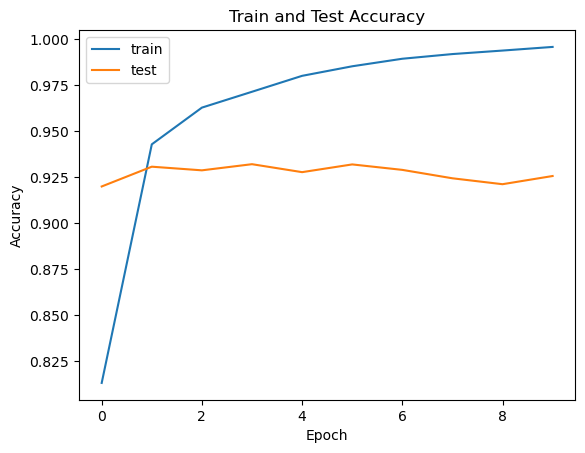

In [ ]:
plt.plot(baseline_model_2.history.history['accuracy'], label='train')
plt.plot(baseline_model_2.history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
test_loss, test_accuracy = baseline_model_2.evaluate([test_sentences, test_ratings], test_labels)
print("Baseline Model 2 test accuracy:", test_accuracy)

253/253 [==============================] - 1s 3ms/step - loss: 0.3141 - accuracy: 0.9256
Baseline Model 2 test accuracy: 0.9255595207214355


# 4. Results Interpretation and Analysis

The test accuracy of models 1 and 2 is 92.2% and 92.6% respectively. This result is already very good, so these models basically achieved our goals. We think word embeddings play the most important role in the models.

Baseline Model 2 shows slightly better performance on the test data (4.1). We believe this improvement comes from the Conv1D layer, which better understands contextual information. To further find why approximately 7% of reviews are not well classified, we read some examples (4.2) and projected the embeddings of reviews into 2D space (4.3).


After reviewing misclassified reviews in section 4.2, we observed common characteristics regardless of whether they are OR or CG reviews. These shared features include: 1) incomplete sentences, and 2) inclusion of irrelevant information. Furthermore, comparing the misclassified CG reviews with their correctly classified counterparts, we did feel these sentences are more real-like, especially we found they have less logical inconsistencies. In contrast, these misclassified OR reviews show some grammatical and logical problems, making them more similiar with CG reviews. Embedding visualization in 4.3 also supported our ideas. These misclassified reviews all locate at the boundary of CG and OR reviews.

Although we found shared characteristics of misclassified CG and OR reviews, we feel that reviews from real humans are more logically correct and complete. Therefore, we think incorporating pre-trained language models, which better capturn contextual information of words, could further improve classification accuracy.

## 4.1. Comparison of the two baseline models

In [ ]:
# test accuracy
test_loss_baseline_model_1, test_accuracy_baseline_model_1 = baseline_model_1.evaluate([test_sentences, test_ratings], test_labels, verbose=0)
test_loss_baseline_model_2, test_accuracy_baseline_model_2 = baseline_model_2.evaluate([test_sentences, test_ratings], test_labels, verbose=0)

print("Baseline Model 1 test accuracy:", test_accuracy_baseline_model_1)
print("Baseline Model 2 test accuracy:", test_accuracy_baseline_model_2)

Baseline Model 1 test accuracy: 0.9220972061157227
Baseline Model 2 test accuracy: 0.9255595207214355


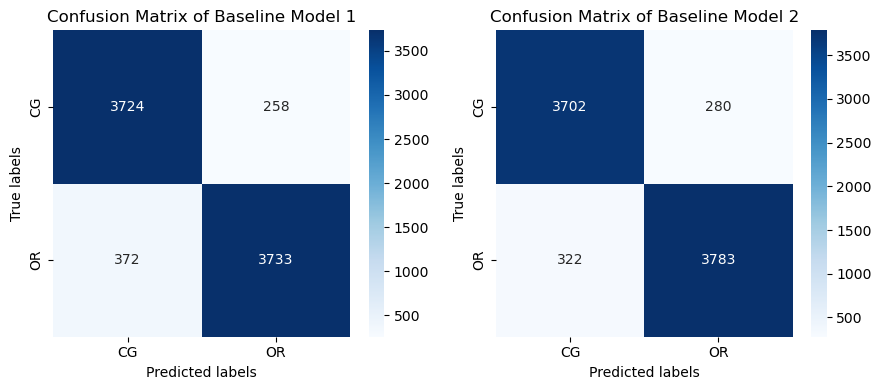

In [ ]:
# calculate confusion matrix for the two models
baseline_model_1_y_pred = (baseline_model_1.predict([test_sentences, test_ratings], verbose=0).squeeze(-1) > 0.5).astype(int)
baseline_model_2_y_pred = (baseline_model_2.predict([test_sentences, test_ratings], verbose=0).squeeze(-1) > 0.5).astype(int)

baseline_model_1_cm = confusion_matrix(test_labels, baseline_model_1_y_pred)
baseline_model_2_cm = confusion_matrix(test_labels, baseline_model_2_y_pred)

# plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# plot confusion matrix of baseline_model_1
sns.heatmap(baseline_model_1_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "OR"], yticklabels=["CG", "OR"], ax=axes[0])
axes[0].set_title('Confusion Matrix of Baseline Model 1')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')

# plot confusion matrix of baseline_model_2
sns.heatmap(baseline_model_2_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "OR"], yticklabels=["CG", "OR"], ax=axes[1])
axes[1].set_title('Confusion Matrix of Baseline Model 2')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')

plt.tight_layout()
plt.show()

## 4.2. Examples of misclassified samples of Baseline Model 2

In [ ]:
# show five misclassified CG reviews
tokenizer.sequences_to_texts(test_sentences[(baseline_model_2_y_pred != test_labels) & (test_labels == 0)])[0:5]

["it was ok didn't find it entertaining not for everyone",
 'absolutely love this sweater got it for my cat and it fit him perfectly he loves to play with it and it',
 "there isn't much room in the back so you have to keep your hands up in order to keep them from falling out",
 'great expansion for coup and pirate the expansion adds a few new things for the pirate to do',
 "i wouldn't actually recommend this book to anyone it just wasn't as good as the first one"]

In [ ]:
# show five misclassified OR reviews
tokenizer.sequences_to_texts(test_sentences[(baseline_model_2_y_pred != test_labels) & (test_labels == 1)])[0:5]

['this product is sturdy and has a nice design will last and last',
 "the kite is easy to put together and take apart to put back in the sleeve the colors are bright and pretty and it flies well what's not to like",
 "the product is just as described and sturdily made but if i wanted another one i'd definitely buy it at a store amazon shipped this small package in a box that measured about 20x14x12 i can't think of any reason to be so wasteful",
 'we love this this is the best costume we have ever bought',
 'great frame wish the backer was a little heavier than cardboard but for the price it is fine']

##### 4.3. Visualize contextualized embeddings

In [ ]:
# project review embeddings into 2D space
review_embeddings, y_pred = Model(inputs=[text_input, rating_input], outputs=[baseline_model_2.layers[6].output, baseline_model_2.layers[7].output])([padded_sequences, ratings], training=False)
y_pred = (y_pred.numpy().squeeze(-1) > 0.5).astype(int)

tsne = TSNE(n_components=2, random_state=109)
sentence_embeddings_dimension_reduction = tsne.fit_transform(review_embeddings)

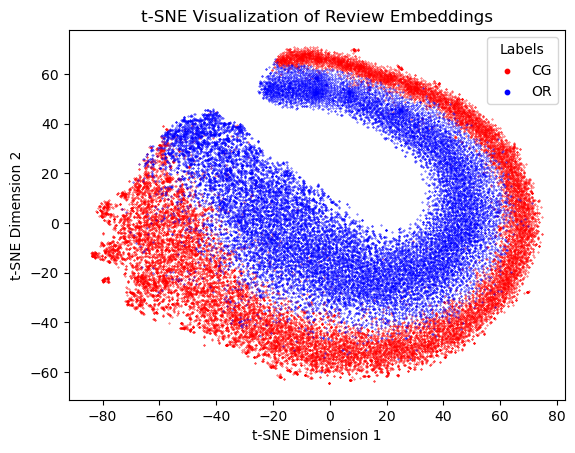

In [ ]:
# Plot the t-SNE embeddings
plt.figure()
id_2_label = {0: "CG", 1: "OR"}
id_2_color = {0: "red", 1: "blue"}
for id in id_2_label.keys():
    plt.scatter(sentence_embeddings_dimension_reduction[labels==id, 0],
                sentence_embeddings_dimension_reduction[labels==id, 1],
                s=0.1, label=id_2_label[id], c=id_2_color[id])
plt.title("t-SNE Visualization of Review Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
legend = plt.legend(title='Labels')

# Adjust size of dots in legend
for handle in legend.legend_handles:
    handle.set_sizes([10])

plt.show()

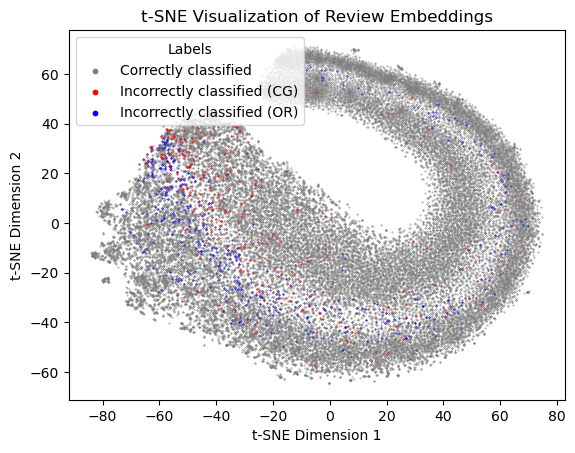

In [ ]:
# Plot the t-SNE embeddings of all misclassified reviews
plt.figure()

plt.scatter(sentence_embeddings_dimension_reduction[:, 0],
            sentence_embeddings_dimension_reduction[:, 1],
            s=0.1, label="Correctly classified", c="grey")

# misclassified reviews
for id in id_2_label.keys():
    label = "Incorrectly classified (" + id_2_label[id] + ")"
    plt.scatter(sentence_embeddings_dimension_reduction[np.logical_and(y_pred != id, labels == id), 0],
                sentence_embeddings_dimension_reduction[np.logical_and(y_pred != id, labels == id), 1],
                s=0.1, label=label, c=id_2_color[id])

plt.title("t-SNE Visualization of Review Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
legend = plt.legend(title='Labels')

# Adjust size of dots in legend
for handle in legend.legend_handles:
   handle.set_sizes([10])

plt.show()

# 5. Final Model Pipeline Setup

### Model Specification
For the final classification model, we plan to utilize and standard texct classification model with a pre-traied language model as the backbone. Given a sentence $S$, which is a string, we make the classification in the following steps:
1. We use a tokenizer to convert $S$ into a sequence of tokens $T \in \mathbb{R}^l$, where $l$ is the length of the sequence after tokenization.
2. We pass $T$ through a pre-trained language model (e.g., BERT) to obtain the contexualized representation $H \in \mathbb{R}^{l\times d}$ of the sentence. Here $d$ is the embedding size of language model.
3. We extract the contecxualization of the CLS token $H_{CLS}$.
    - If we decide to use the structured features $F_s \in \mathbb{R}^s$, we concatenate the structured features to $H_{CLS}$. Namely, $H_{CLS} \leftarrow Concat(H_{CLS}, F_s)$, and $d \leftarrow d + s$
    - We have 11 structrued features ($s = 11$). i.e., 1 for `Rating` and 10 for the 10 classes in `Category` (encoded in one-hot form)
4. We use a linear layer to predict the class distribution. i.e., we compute the distribution of labels $P = \text{Softmax}(WH_{CLS} + b)$, where $W \in \mathbb{R}^{2 \times d}$ and $P, b \in \mathbb{R}^2$

### Experimental Setup
As described in pervious part, we choose to use a pre-trained language model as the backbone as the major differences between CG and OR samples lies in syntatic features, which is a kind of contecxualized features very well modelled by transformers. We decide to use pre-trained language models due to their enhanced ability of language comprehension gained in the process of large-scale pretraining. Here are some (default) hyperparameter choices and their rationales.
- optimizer: Adam. Typically the default choice in NLP due to fast convergence.
- Learning rate: 2e-5. A very small learning rate is typically better in finetuning (large) pre-trained models.
- Train/Test split: Since the dataset does not give a categorization of train/test split, we use the first 70% data for training, 10% data for validation, and last 20% of the data for testing/evaluation. We take the model with best performance on the training set and evaluate it on the test set to prevent overfitting/unfair comparison.
- Pre-trained LM choice: the structure works with any PLMs. However, we use RoBERTa-base as the default option due to its robustness and superior performance as compared to BERT across many tasks.

### Github
In running experiment, we organize the files in the Github across multiple files so that we can run experiment using shell commands. The link is below and see README.md to see how to run the experiment from command line.

https://github.com/TonyW42/cs209/tree/milestone4_shulin

## 5.1 Loading the data

In [2]:
class classification_dataset(Dataset):
    def __init__(self, df, tokenizer, label_2_id, args):
        self.df = df
        self.args = args
        self.tokenizer = tokenizer
        self.label_2_id = label_2_id
        self.categories = [
            'Books_5', 'Clothing_Shoes_and_Jewelry_5',
            'Electronics_5','Home_and_Kitchen_5', 'Kindle_Store_5',
            'Movies_and_TV_5','Pet_Supplies_5', 'Sports_and_Outdoors_5',
            'Tools_and_Home_Improvement_5', 'Toys_and_Games_5'
            ]
        self.categroy2id = {self.categories[i]: i for i in range(len(self.categories))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokenized = self.tokenizer(self.df["text_"][idx],
                                   padding = "max_length",
                                   truncation = True )
        tokenized["label"] = self.label_2_id[self.df["label"][idx]]
        if self.args.other_features:
            category = self.df.category[idx]
            category_id = self.categroy2id[category]
            category_binary = [1 if i == category_id else 0 for i in range(len(self.categories))]
            category_binary.append(self.df.rating[idx]) ## add ratings
            tokenized["other_features"] = category_binary
        for k, v in tokenized.items():
            tokenized[k] = torch.tensor(v)
        return tokenized

def get_data(args):
    df = pd.read_csv("fake reviews dataset.csv")
    label_2_id = {"CG":0, "OR": 1}
    train_df = df.iloc[:int(len(df) * args.train_size), :].reset_index(drop=True)
    dev_df = df.iloc[int(len(df) * args.train_size) : int(len(df) * (args.train_size + args.dev_size)), :].reset_index(drop=True)
    test_df = df.iloc[int(len(df) * (args.train_size + args.dev_size)):, :].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(args.model_name)

    traindataset = classification_dataset(train_df, tokenizer, label_2_id, args)
    devdataset = classification_dataset(dev_df, tokenizer, label_2_id, args)
    testdataset = classification_dataset(test_df, tokenizer, label_2_id, args)

    trainloader = DataLoader(traindataset, batch_size = args.bs, shuffle=True)
    devloader = DataLoader(devdataset, batch_size = args.bs, shuffle=True)
    testloader = DataLoader(testdataset, batch_size = args.bs, shuffle=True)

    return trainloader, devloader, testloader

## 5.2 Defining the Model

In [3]:
class baseline_model(nn.Module):
    def __init__(self, lm, args):
        super(baseline_model, self).__init__()
        self.lm = lm
        self.args = args
        feature_size =  args.emb_size
        if args.other_features : feature_size += args.feature_size
        self.head = nn.Linear(feature_size, args.num_labels)

    def forward(self, data):
        encoded = self.lm(
            input_ids = data["input_ids"].to(self.args.device),
            attention_mask = data["attention_mask"].to(self.args.device)
        )
        emb = encoded["pooler_output"]
        if self.args.other_features:
            emb = torch.cat((emb, data["other_features"].type(torch.float).to(self.args.device)), dim = -1)
        logits = self.head(emb)
        return logits

## 5.3 Define Trainer for training

In [4]:
class baseline_classifier:
    def __init__(self, model, criterion, optimizer, args):
        self.model = model
        self.args = args
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, trainloader, devloader, testloader):
        tbar = tqdm(trainloader, dynamic_ncols=True)
        for data in tbar:
            self.optimizer.zero_grad()
            logits = self.model(data)
            loss = self.criterion(logits, data["label"].to(self.args.device))
            loss.backward()
            self.optimizer.step()
            tbar.set_description("train_loss - {:.4f}".format(loss))
        dev_acc=  self._eval(devloader)
        test_acc=  self._eval(testloader)
        return dev_acc, test_acc

    def train(self, trainloader, devloader, testloader):
        test_accs, dev_accs = [], []
        for i in range(self.args.n_epochs):
            dev_acc, test_acc = self._train_epoch(trainloader, devloader, testloader)
            dev_accs.append(dev_acc)
            test_accs.append(test_acc)
            print("=" * 20)
            print(f"dev acc: {dev_acc}")
            print(f"test acc: {test_acc}")
            print("=" * 20)
        return dev_accs , test_accs

    def _eval(self, dataloader):
        with torch.no_grad():
            tbar = tqdm(dataloader, dynamic_ncols=True)
            preds = []
            labels = []
            for data in tbar:
                logits = self.model(data)
                pred = torch.argmax(logits, dim=-1)
                label = data["label"]
                preds.extend(pred.detach().cpu().tolist())
                labels.extend(label.cpu().tolist())
            acc = np.sum(np.equal(preds, labels)) / len(preds)
            return acc

def run_baseline_experiment(args):
    trainloader, devloader, testloader = get_data(args)
    lm = AutoModel.from_pretrained(args.model_name)
    model = baseline_model(lm, args)
    model.to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)
    criterion = nn.CrossEntropyLoss()
    classifier = baseline_classifier(model, criterion, optimizer, args)
    dev_accs , test_accs = classifier.train(trainloader, devloader, testloader)
    test_acc_chosen = test_accs[np.argmax(dev_accs)]
    return test_acc_chosen, dev_accs , test_accs

## 5.4 Define Hyperparameters ("args")

In [5]:
class default_config:
    def __init__(self):
        self.emb_size = 768
        self.bs = 8
        self.lr = 2e-5
        self.other_features = False
        self.num_labels = 2
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.n_epochs = 2
        self.train_size = 0.7
        self.dev_size = 0.1
        self.model_name = "roberta-base"
        self.feature_size = 11

In [6]:
## modify the arguments here
## args.xxx = xxx
args = default_config()

## 5.5 Run experiments

### 5.5.1 Run experiments without structured features

In [ ]:
print(f"Add other features:{args.other_features}")
test_acc_chosen, dev_accs , test_accs = run_baseline_experiment(args)
print(f"Test acc is: {test_acc_chosen}")
print(f"All dev acc {dev_accs}")
print(f"All test acc {test_accs}")


Add other features:False


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1011/1011 [04:06<00:00,  4.11it/s]


dev acc: 0.9606727677467227
test acc: 0.9557314207988129


100%|██████████| 1011/1011 [04:06<00:00,  4.10it/s]


dev acc: 0.9792233489982686
test acc: 0.9744033634227773


100%|██████████| 1011/1011 [04:06<00:00,  4.11it/s]

dev acc: 0.9802127133316844
test acc: 0.9740323976752813
Test acc is: 0.9740323976752813
All dev acc [0.9606727677467227, 0.9792233489982686, 0.9802127133316844]
All test acc [0.9557314207988129, 0.9744033634227773, 0.9740323976752813]


### 5.5.2 Run experiments with structured features (rating and category)

In [7]:
args = default_config()
args.other_features = True
print(f"Add other features:{args.other_features}")
test_acc_chosen, dev_accs , test_accs = run_baseline_experiment(args)
print(f"Test acc is: {test_acc_chosen}")
print(f"All dev acc {dev_accs}")
print(f"All test acc {test_accs}")

Add other features:True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1011/1011 [02:18<00:00,  7.28it/s]


dev acc: 0.9777393024981449
test acc: 0.9737850871769507


100%|██████████| 1011/1011 [02:18<00:00,  7.29it/s]

dev acc: 0.9784813257482068
test acc: 0.9724248794361321
Test acc is: 0.9724248794361321
All dev acc [0.9777393024981449, 0.9784813257482068]
All test acc [0.9737850871769507, 0.9724248794361321]


## 5.5 Preliminary Results

BERT fine-tuned without rating and category information for each review achieved 97.4% accuracy on the test set within 2 training epochs and the accuracy did not increase for the third epoch. A similar test accuracy 97.4% was achieved after the first training epoch when rating and category information was concatenated to the embedding for each review. Using BERT successfully improved task performance compared to our baseline model. Adding rating and category information did not further improve model performance.

## 5.6 Future Steps

In the final submission, we plan to do more analysis of the results (e.g., looking at misclassified samples and report conbfusion matrices). We also plan to investigate whether our model is able to recognize fake reviews generated by more advanced AI. To that end, we plan to leverage large language models (e.g., LLaMa-2) to re-write the CG samples and repeat the experiment on the new dataset. Time permitting, we also plan to implement LLM as classifiers via in-context learning.

# 6. TF Meeting

We met with our TF on 04/17. There is a few takeaways:
1. We briefly discussed the task and the current progress.
2. The performance of the baseline and the final model is already very good.
3. Instead of further improving the accuracy, we could do further analysis (e.g., many ideas mentioned in section 5.6).
4. We discussed some minor administrative issues.

The (existing and planned division of labor is as follows):
- Lily: Qualitative analysis of the data. (TODO) Dataset regeneration using LLM in section 5.6
- shulin: Implemented and baseline model and running experiments. (TODO) Incontext learning in section 5.6
- Yilin: Implemented the final model and running experiments. (TODO) deploy LLMs for section 5.6

Some shared tasks and responsibilities include: EDA (each member created plots of the data); writeups of each milestone;